# Aperture Photometry of a Type Ia Supernova

Aperture Photometry
* isolated sources
* take an aperture that includes all your sources
* subtract a background either from a second aperature or an annulus
* Use PSF photometry for crowded fields

For HW:
* take one star from catalog that Stefano gives us and put the coordinate and the magnitude of that object

In homework: use this value to find the distance to the SN  
* All SN Ia have approximately the same peak brightness  
* distance modulus = m-M  
* plot the light curve (ideally with sigma clipping)  
* pick reference star  
* do the calibration  
* find the maximum  
* measure the distance modulus  
* 1 figure (with caption and labels)
* what you did
* why you can use Ia as standard candle
* using 1st order approximation

In [2]:
import glob
import os
import numpy as np
from scipy.interpolate import UnivariateSpline

from astropy import wcs
from astropy.io import fits, ascii as asc
from astropy.stats import sigma_clipped_stats,mad_std
from astropy.modeling import fitting, models
from astropy import table
import astropy.units as u

from photutils import  aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder
from photutils.utils import calc_total_error


# needed for interactive plots
%matplotlib notebook
import matplotlib.pyplot as plt 

from utilities_az import visualization

## make a list with images in this directory

In [3]:
imglist_all = sorted(glob.glob(os.path.join('NGC3923/','*fits')))
imglist = []
for img in imglist_all:
    if ('NGC3923_2018-04-29.06.fits' not in img) and ('NGC3923/NGC3923_2018-05-03.25.fits' not in img):
        imglist.append(img)
len(imglist)

99

## Choose reference star

In [4]:
! HEAD -n 15 NGC3923_apass.cat

# BEGIN CATALOG HEADER
# nfields 13
#     ra     1  0 d degrees %10.5f
#     dec    2  0 d degrees %10.5f
#     id     3  0 c INDEF %15s
#     B      4 0 r INDEF %6.2f
#     Berr   5 0 r INDEF %6.2f
#     V      6 0 r INDEF %6.2f
#     Verr   7 0 r INDEF %6.2f
#     g      8 0 r INDEF %6.2f
#     gerr   9 0 r INDEF %6.2f
#     r      10 0 r INDEF %6.2f
#     rerr   11 0 r INDEF %6.2f
#     i      12 0 r INDEF %6.2f
#     ierr   13 0 r INDEF %6.2f


<IPython.core.display.Javascript object>


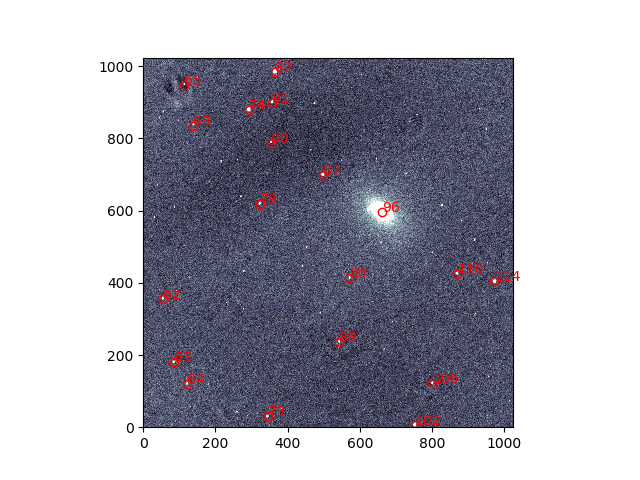

(0, 1024)

In [5]:
apass_cat = asc.read('NGC3923_apass.cat', 
                     names=['ra', 'dec', 'id', 'B', 'Berr', 'V', 'Verr', 'g', 'gerr', 'r', 'rerr', 'i', 'ierr'])

ofile = fits.open(imglist[0])
img = ofile[0].data
hdr = ofile[0].header
vmin, vmax = visualization.zscale(img)
img_wcs = wcs.WCS(hdr)
x_apass, y_apass = img_wcs.all_world2pix(apass_cat['ra'], apass_cat['dec'], 0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img, vmin=vmin, vmax=vmax, cmap='bone')
ax.plot(x_apass, y_apass, 'o', mfc='none', mec='r')
use_indx = (x_apass>0)&(x_apass < img.shape[1])&(y_apass>0) & (y_apass<img.shape[0])
for x, y, i in zip(x_apass[use_indx], y_apass[use_indx], apass_cat['id'][use_indx]):
    ax.text(x, y, i, color='r')
ax.set_xlim(0, img.shape[1])
ax.set_ylim(0, img.shape[0])


#### Use all reference stars in image

In [30]:
# reference stars coordinates and r band magnitude
ref_stars = apass_cat[use_indx]
print(len(ref_stars))

19


## Set info about SN

In [7]:
# SN coordinate 
ra_SN,dec_SN = 177.7574 , -28.74400
Ar_mw = 0.228
abs_mag = -19.03
abs_mag_err = 0.01

In [8]:
x,y = img_wcs.all_world2pix(ra_SN, dec_SN, 0)
print(x, y)

666.0143203848293 214.91127423860792


## Verify Aperture Size with COG

<IPython.core.display.Javascript object>


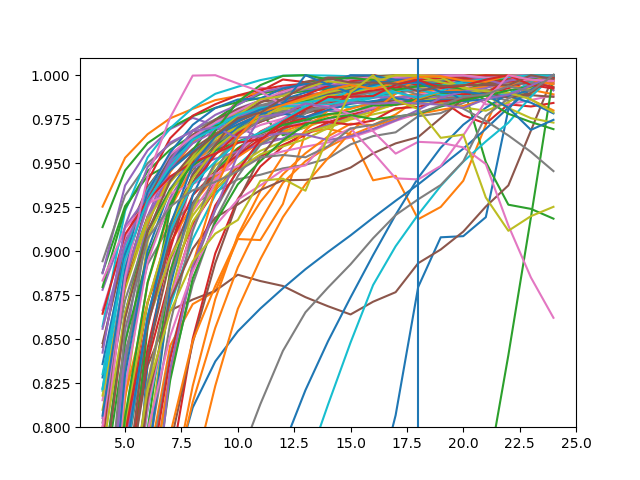

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
radii = np.arange(4,25)
lines = []
for img in imglist:
    # use fits to read header of each image and data matrix
    data, header0 = fits.getdata(img, header=True)
    gain = header0['GAIN']   # AADU/electrons; need to get poisson errror

    # read wcs solution from header
    sn_wcs = wcs.WCS(header0) #gives translation of pixel space to sky coordinates
    
    #  This is for the SN 
    #  Transform ra and dec in pixels
    x_SN, y_SN = sn_wcs.all_world2pix(ra_SN, dec_SN, 1)
    apertures_SN = [CircularAperture((x_SN, y_SN), r=r) for r in radii]#radius in pixels - looks big enough to include full object
    annulus_apertures_SN = CircularAnnulus((x_SN, y_SN), r_in=30., r_out=34.)
    # measure fluxes in the aperture and in the annulus 
    apertures_SN.append(annulus_apertures_SN)
    #Perform the photometry; gives gross counts of SN and background
    phot_table = aperture_photometry(data, apertures_SN) 
    mag = []
    for icol,r, iaper in zip(phot_table.colnames[3:], radii, apertures_SN[:-1]):
        mag.append(phot_table[icol]-(phot_table[phot_table.colnames[-1]]*iaper.area()/apertures_SN[-1].area()))
    ax.plot(radii, mag/max(mag))
        
plt.ylim(0.8, 1.01)
plt.axvline(18)

# Try with FWHM of 2D Gaussian

<IPython.core.display.Javascript object>


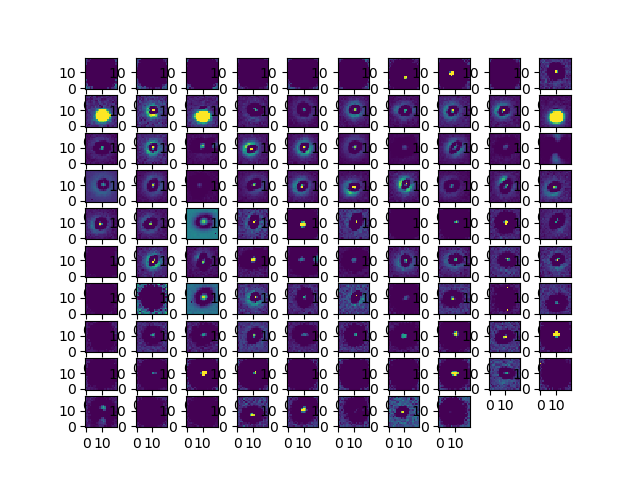

6.032213806898346
5.511617203211202


In [117]:
fig = plt.figure()
xfwhm = []
yfwhm = []
fitter = fitting.LevMarLSQFitter()
sigma_psf = 1.0
xx = 10
psf_mod = models.Gaussian2D(x_stddev=sigma_psf, y_stddev=sigma_psf, x_mean=xx, y_mean=xx)
psf_mod.bounds['x_stddev']=(0.25, 4)
psf_mod.bounds['y_stddev']=(0.25, 4)
psf_mod.bounds['x_mean'] = (xx-4, xx+4)
psf_mod.bounds['y_mean'] = (xx-4, xx+4)


for indx, img in enumerate(imglist):
    # use fits to read header of each image and data matrix
    data, header0 = pyfits.getdata(img, header=True)
    gain = header0['GAIN']   # AADU/electrons; need to get poisson errror

    # read wcs solution from header
    sn_wcs = wcs.WCS(header0) #gives translation of pixel space to sky coordinates

    
    #  This is for the SN 
    #  Transform ra and dec in pixels
    x_SN, y_SN = sn_wcs.all_world2pix(ra_SN, dec_SN, 1)

    y, x = np.mgrid[:2*xx, :2*xx]
    datatrim = data[int(y_SN-xx):int(y_SN+xx), int(x_SN-xx):int(x_SN+xx)]
    if datatrim.shape!=(2*xx, 2*xx):
        imglist.pop(indx)
        print('removing {}'.format(img))
        continue
    else:
        ax = fig.add_subplot(10,10, indx+1)
        ipsf_mod = fitter(psf_mod, x, y, datatrim/np.max(datatrim))
        xfwhm.append(ipsf_mod.x_fwhm)
        yfwhm.append(ipsf_mod.y_fwhm)
        vmin, vmax = visualization.zscale(datatrim/datatrim.max())
        ax.imshow(datatrim/datatrim.max()-ipsf_mod(x,y), vmin=vmin, vmax=vmax)
xfwhm = np.array(xfwhm)
yfwhm = np.array(yfwhm)
print(np.median(xfwhm))
print(np.median(yfwhm))

#### Use 18'' as an aperture

## loop over the images and measure the flux with aperture (in pixel)

In [26]:
jd = []
phot_tab_sn = None
phot_tab_ref = None
for img in imglist:
    # use fits to read header of each image and data matrix
    data, header0 = fits.getdata(img, header=True)
    gain = header0['GAIN']   # AADU/electrons; need to get poisson errror

    # read wcs solution from header
    sn_wcs = wcs.WCS(header0) #gives translation of pixel space to sky coordinates
    
    #  This is for the SN 
    #  Transform ra and dec in pixels
    x_SN, y_SN = sn_wcs.all_world2pix(ra_SN, dec_SN, 1)
    position_SN = (x_SN, y_SN)
    
    #Check whether the noise is the same for the full image and the region around supernova (+/-25 pix)
    # Compute the background standard deviation only on a trim region
    xx = 25
    datatrim = data[int(y_SN-xx):int(y_SN+xx), int(x_SN-xx):int(x_SN+xx)]
    mean, median, sky_std_trim = sigma_clipped_stats(datatrim, sigma=3.0, iters=5)
    
    # Compute error: Poisson + background 
    error = calc_total_error(data, sky_std_trim, gain)  
        
    # define aperture magnitude with daophot astropy util package
    # determine aperture either from 3-4x FWHM of PSF or use a fixed aperture
    # r=15 is fine for homework
    apertures_SN = CircularAperture(position_SN, r=18.) #radius in pixels - looks big enough to include full object
    # define annulus for background with daophot astropy util package
    annulus_apertures_SN = CircularAnnulus(position_SN, r_in=20., r_out=24.)
    # measure fluxes in the aperture and in the annulus 
    apers_SN = [apertures_SN, annulus_apertures_SN] 
    #Perform the photometry; gives gross counts of SN and background
    phot_table = aperture_photometry(data, apers_SN, error=error)  
    phot_table['jd'] = [header0['JD']]
    #  To Convert counts to magnitudes
    #  Repeat process for the REFERENCE STAR 
    #  Transform ra and dec in pixels
    x_ref, y_ref = sn_wcs.all_world2pix(ref_stars['ra'], ref_stars['dec'], 1)
    positions_ref = [(x,y) for x,y in zip(x_ref, y_ref)]

    # define aperture magnitude with daophot astropy util package
    apertures_ref = CircularAperture(positions_ref, r=18.)    #this should match 
    # define annulus for background with daophot astropy util package
    annulus_apertures_ref = CircularAnnulus(positions_ref, r_in=20., r_out=24.)
    # measure fluxes in the aperture and tin the annulus 
    apers_ref = [apertures_ref,annulus_apertures_ref]
    phot_table2 = aperture_photometry(data, apers_ref, error=error) 
    phot_table2['jd'] = [header0['JD']]
    if not phot_tab_sn:
        phot_tab_sn = phot_table
        phot_tab_ref = phot_table2
    else:
        phot_tab_sn = table.vstack((phot_tab_sn, phot_table))
        phot_tab_ref = table.vstack((phot_tab_ref, phot_table2))
    
print('DONE')


/Users/bostroem/anaconda/envs/astroconda36/lib/python3.6/site-packages/photutils/aperture/core.py:306: UserWarning: Warning: converting a masked element to nan.
  output = np.array(_list)


DONE


In [27]:
#You can use the group by function for mixin tables so remove the columsn that have units associated with them
phot_tab_sn.remove_columns(['xcenter', 'ycenter'])
phot_tab_ref.remove_columns(['xcenter', 'ycenter'])

In [28]:
bkg_sn = phot_tab_sn['aperture_sum_1']/annulus_apertures_SN.area() * apertures_SN.area()
phot_tab_sn['flux'] = phot_tab_sn['aperture_sum_0'] - bkg_sn

# Compute error  sqrt( DF_aperture^2 + DF_annulu^2)
phot_tab_sn['flux_err'] = np.sqrt(phot_tab_sn['aperture_sum_err_0']**2 + (phot_tab_sn['aperture_sum_err_1']
                             * apertures_SN.area()/annulus_apertures_SN.area())**2) #sn_err**2 + bgk_err**2    

## Compute mean background in the annulus and total background for the aperture 
bkg_sum_ref = phot_tab_ref['aperture_sum_1']/annulus_apertures_ref.area() * apertures_ref.area()
#
## Compute final aperture flux for the SN and update the table
phot_tab_ref['flux'] = phot_tab_ref['aperture_sum_0'] - bkg_sum_ref
#
# Compute error  sqrt( DF_aperture^2 + DF_annulu^2)
phot_tab_ref['flux_err'] = np.sqrt(phot_tab_ref['aperture_sum_err_0']**2 + (phot_tab_ref['aperture_sum_err_1'] 
                         * apertures_SN.area()/annulus_apertures_ref.area())**2)

## convert flux in magnitude 

In [29]:
#Define instrumental magnitudes
phot_tab_sn['mag_inst'] = -2.5*np.log10(phot_tab_sn['flux'])
phot_tab_ref['mag_inst'] = -2.5*np.log10(phot_tab_ref['flux'])

#Comes from error propogation to equation above
phot_tab_sn['mag_inst_err'] = 1.0857 * phot_tab_sn['flux_err'] / phot_tab_sn['flux']
phot_tab_ref['mag_inst_err'] = 1.0857 * phot_tab_ref['flux_err'] / phot_tab_ref['flux']
ref_zpt = []
while len(ref_zpt) < len(phot_tab_ref):
    ref_zpt += list(ref_stars['r'])
phot_tab_sn['zpt'] = phot_tab_sn['mag_inst'] #create a dummy array to fill
phot_tab_sn['zpt_err'] = phot_tab_sn['mag_inst_err']
phot_tab_ref['zeropoint'] = phot_tab_ref['mag_inst'] - np.array(ref_zpt)
#Loop over each date and find zeropoint
for jd_group in phot_tab_ref.group_by('jd').groups:
    zpt_mean, zpt_median, zpt_std = sigma_clipped_stats(jd_group['zeropoint'][np.isfinite(jd_group['zeropoint'])], sigma=3.0, iters=5)
    phot_tab_sn['zpt'][phot_tab_sn['jd']==jd_group['jd'][0]] = zpt_mean
    phot_tab_sn['zpt_err'][phot_tab_sn['jd']==jd_group['jd'][0]] = zpt_std
    
phot_tab_sn['app_mag'] = phot_tab_sn['mag_inst'] - phot_tab_sn['zpt']
phot_tab_sn['app_mag_err'] = np.sqrt(phot_tab_sn['mag_inst_err']**2 + phot_tab_sn['zpt_err']**2)

/Users/bostroem/anaconda/envs/astroconda36/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


## fit the light curve

In [47]:
# remove nan points and points with larger errors
phot_tab_sn.sort('jd')
clean_indx = (np.isfinite(phot_tab_sn['app_mag'])) & (phot_tab_sn['app_mag_err']<0.5)

# fit the light curve to find the maximum 
spl = UnivariateSpline(phot_tab_sn['jd'][clean_indx], phot_tab_sn['app_mag'][clean_indx], w=1/phot_tab_sn['app_mag_err'][clean_indx], k=5)
fit = spl(phot_tab_sn['jd'])

/Users/bostroem/anaconda/envs/astroconda36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


<IPython.core.display.Javascript object>


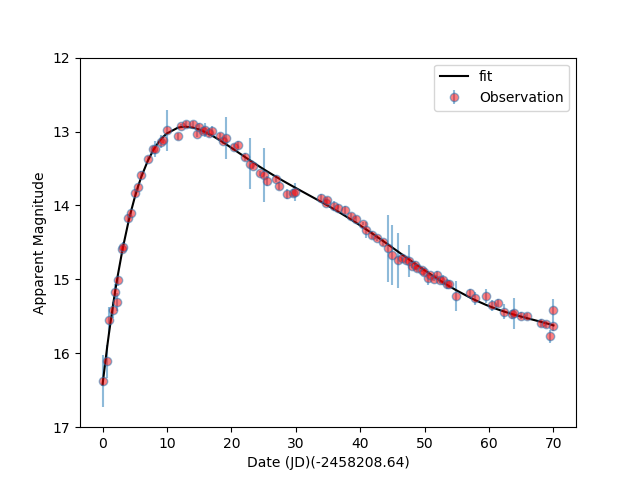

the maximum is 12.936003


In [48]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(phot_tab_sn['jd'][clean_indx]-phot_tab_sn['jd'][0], phot_tab_sn['app_mag'][clean_indx], 
            yerr= phot_tab_sn['app_mag_err'][clean_indx], 
            mfc='red', fmt='o', label='Observation', alpha=0.5)
ax.set_ylim(17,12)

ax.plot(phot_tab_sn['jd']-phot_tab_sn['jd'][0], fit,'-k', label='fit')
xx = np.arange(0,40,.1)
index = np.argmin(fit)
max_app_mag = fit[index]
print('the maximum is %f' % (fit[index]))
ax.set_xlabel('Date (JD)(-{:6.2f})'.format(phot_tab_sn['jd'][0]))
ax.set_ylabel('Apparent Magnitude')
ax.legend()
plt.savefig('light_curve.pdf')
# WE only care about the fit to the maximum

In [43]:
phase = phot_tab_sn['jd'] - np.min(phot_tab_sn['jd'])

# compute polinomial fit
z = np.polyfit(phase[clean_indx], phot_tab_sn['app_mag'][clean_indx], 9)
# use the output of the fit to make a polinomial function
p = np.poly1d(z)

# evaluate the polynomial function 
pfit  = np.arange(np.max(phase))
kkfit = p(pfit)

# fit the light curve to find the maximum 


<IPython.core.display.Javascript object>


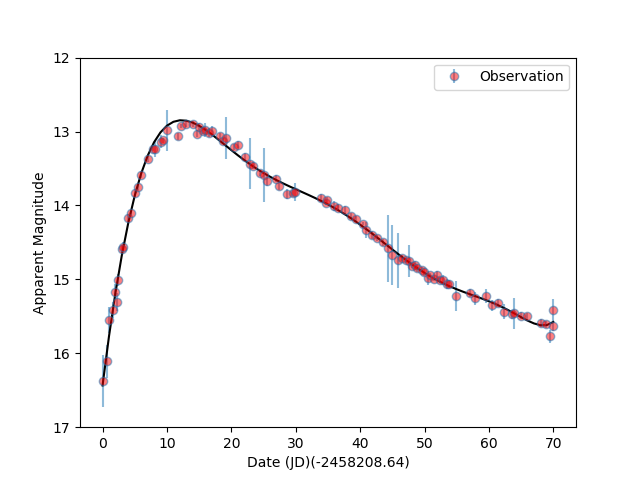

the maximum is 12.847828


In [49]:
fig, ax = plt.subplots(1, 1)
ax.errorbar(phot_tab_sn['jd'][clean_indx]-phot_tab_sn['jd'][0], phot_tab_sn['app_mag'][clean_indx], 
            yerr= phot_tab_sn['app_mag_err'][clean_indx], 
            mfc='red', fmt='o', label='Observation', alpha=0.5)
ax.set_ylim(17,12)

ax.plot(pfit, kkfit,'-k')
index = np.argmin(kkfit)
print('the maximum is %f' % (kkfit[index]))
ax.set_xlabel('Date (JD)(-{:6.2f})'.format(phot_tab_sn['jd'][0]))
ax.set_ylabel('Apparent Magnitude')
ax.legend()
plt.savefig('light_curve2.pdf')
# WE only care about the fit to the maximum

## Calculate the Distance Modulus

$\mu=m_{r}^{max} - M_{r} - b_{r}[\Delta m_{15} -1.1] - R_{r} E(B-r)$  
We're going to ignore the middle term and the redenning term and include MW extinction, so we're calculating:  
$\mu=m_{r}^{max} - M_{r}-A_{r}$  

In [316]:
dist_mod =  max_app_mag - abs_mag - Ar_mw
dist_mod_err = abs_mag_err  #assuming no error in fit or reddening
print(dist_mod)
dist = 10**((dist_mod+5)/5)*u.parsec
dist_err = np.sqrt((np.log(10)*dist/5 * dist_mod_err)**2)
print('distance = {:2.2f} +/- {:2.3f}'.format(dist.to(u.Mpc), dist_err.to(u.Mpc)))

31.73800320571867
distance = 22.26 Mpc +/- 0.103 Mpc


In [17]:
phot_tab_sn.colnames

['id',
 'aperture_sum_0',
 'aperture_sum_err_0',
 'aperture_sum_1',
 'aperture_sum_err_1',
 'jd',
 'flux',
 'flux_err',
 'mag_inst',
 'mag_inst_err',
 'zpt',
 'zpt_err',
 'app_mag',
 'app_mag_err']

In [53]:
write_table = table.Table()
write_table.add_columns([phot_tab_sn['jd'], 
                         phot_tab_sn['app_mag'], 
                         phot_tab_sn['app_mag_err']])
write_table.rename_column('jd', 'JD')
write_table.rename_column('app_mag', 'Apparent magnitude')
write_table.rename_column('app_mag_err', 'Apparent magnitude error')
write_table.write('phot_tab.csv', overwrite=True, format='ascii.commented_header', delimiter=',')